In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as ac 
from astroquery.splatalogue import Splatalogue
import astropy.units as u
from helpers import generate_smart_table, LTEmodel, get_CDMS_partition_function

ckms = ac.c.to(u.km/u.s).value


In [21]:
# lines of interest
specie = [
    "NH3",
    "NH2D",
    "NHD2",
    "ND3",
]  # spaces are needed to specify the particular ones

# frequency range of interest 
nu_range = (290 * u.GHz, 330 * u.GHz)

line_query = {}
specie_id = {}
pf = {}
for s in specie:
    if s == "NH3":
        chemical_name = " NH3 v=0 "
        pf_name = "NH3-wHFS"
    else:
        chemical_name = " {:s} ".format(s)
        pf_name = s
    q = Splatalogue.query_lines(
        *nu_range,
        chemical_name=chemical_name,
        line_lists=["CDMS", "JPL"],
        show_upper_degeneracy=True,
        # line_strengths=["ls4"],
        # energy_type="eu_k",
    )
    # id = Splatalogue.get_species_ids(chemical_name)
    # specie_id[s] = id
    line_query[s] = generate_smart_table(q)
    pf[s] = get_CDMS_partition_function(pf_name)
line_query

[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 1766.44451274 1141.03771632  623.73483548
  225.42392122   84.10077541   34.80166322   17.21075808   12.53429755
   12.01157618]
[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 3793.14984974 2466.03933723 1346.79036263
  481.61499484  174.58221529   64.90826491   25.46243891           nan
           nan]
[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 3970.08678112 2580.47704444 1407.99139304
  502.68971537  181.55156628   67.06562867   25.95971977   12.52275835
    9.05107159]
[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 5313.73632119 3455.41329578 1886.68762122
  673.13163273  242.54928571   89.43345319   35.285

{'NH3': <Table length=10>
 Species       QNs       nu0 [GHz]  logA [s^-1] Smu2 [D^2]   g_u    E_u [K]  
   str6       str15       float64     float64    float64   float64  float64  
 ------- --------------- ---------- ----------- ---------- ------- ----------
  NH3v=0 10(1)0a-10(2)0a 319.876327    -8.57903    0.00029    42.0 1554.20729
  NH3v=0 10(1)0s-10(2)0s 320.195675    -8.37844    0.00046    42.0 1553.63057
  NH3v=0   9(1)0a-9(2)0a 322.373122     -8.7561    0.00017    38.0 1272.70067
  NH3v=0   9(1)0s-9(2)0s 322.735616    -8.53037    0.00029    38.0 1272.04732
  NH3v=0   8(1)0a-8(2)0a 324.663166    -8.95498      9e-05    34.0 1018.58102
  NH3v=0   8(1)0s-8(2)0s   325.0697     -8.7038    0.00017    34.0 1017.84992
  NH3v=0   7(1)0a-7(2)0a 326.733914    -9.18062      5e-05    30.0   792.0811
  NH3v=0   7(1)0s-7(2)0s 327.184356    -8.90431      9e-05    30.0  791.27283
  NH3v=0   6(1)0a-6(2)0a  328.57358     -9.4407      2e-05    26.0  593.41213
  NH3v=0   6(1)0s-6(2)0s 329.066699   

In [22]:
# assume IRAS 16293 abundance

N = {'NH3': 5.3e20 * 0.05,
     'NH2D': 5.3e20 * 0.05 * 4e-3,
     'NHD2': 5.3e20 * 0.05 * 4e-3 * 1.8e-2,
     'ND3': 5.3e20 * 0.05 * 4e-3 * 1.8e-2 * 1.8e-2,
     #'15NH3': 5.3e20 * 0.05 / 300.
    }

Tex = 130
DeltaV = 2.0

beam = 0.7 * u.arcsec # in arcsec
source_size = 0.7 * u.arcsec # in arcsec
f = source_size ** 2 / (source_size ** 2 + beam ** 2)
beam_area = np.pi / (4 * np.log(2)) * beam ** 2

# axis
nu_min = nu_range[0].value*1e9
nu_max = nu_range[1].value*1e9
dnu = nu_min / ckms * DeltaV / 5.0
nu = np.arange(nu_min, nu_max, dnu)

I_all = {}
tau_all = {}
for s in specie:
    I_all_s = 0
    tau_all_s = 0
    for trans in line_query[s]:
        I, t = LTEmodel(
            nu=nu,
            nu0=trans["nu0 [GHz]"] * 1e9,
            g_u=trans["g_u"],
            E_u=trans["E_u [K]"],
            A_ul=10 ** trans["logA [s^-1]"],
            N=N[s],
            Tex=Tex,
            DeltaV=DeltaV,
            f=f,
            Q=pf[s](Tex),
        )

        

        I_all_s += I.to(u.Jy/u.sr)
        tau_all_s += t
    I_all[s] = I_all_s.to(u.mJy/u.beam, equivalencies=u.beam_angular_area(beam_area))
    tau_all[s] = tau_all_s
I_all

{'NH3': <Quantity [0., 0., 0., ..., 0., 0., 0.] mJy / beam>,
 'NH2D': <Quantity [0., 0., 0., ..., 0., 0., 0.] mJy / beam>,
 'NHD2': <Quantity [0., 0., 0., ..., 0., 0., 0.] mJy / beam>,
 'ND3': <Quantity [0., 0., 0., ..., 0., 0., 0.] mJy / beam>}

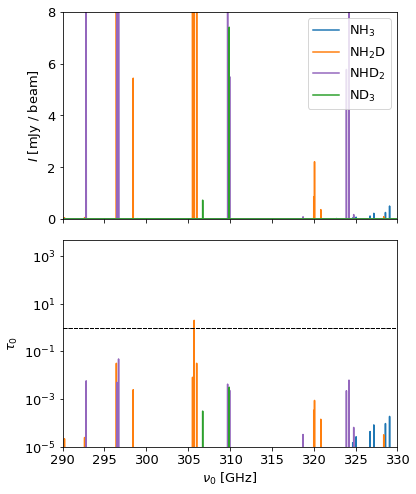

In [25]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

xlim = (290, 330)
#xlim = (306, 306.1)
color = {'NH3': 'tab:blue',
         'NH2D': 'tab:orange',
         'NHD2': 'tab:purple',
         "ND3": "tab:green"}

label = {'NH3': 'NH$_3$',
         'NH2D': 'NH$_2$D',
         'NHD2': 'NHD$_2$',
         'ND3': 'ND$_3$'}

for s in specie:
    # intenisty
    ax[0].plot(nu*1e-9, I_all[s], color=color[s], label=label[s])
    ax[0].grid()
    ax[0].set(xlim=xlim, ylim=(0, 8), ylabel=r'$I$ [mJy / beam]')
    #ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    #ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax[0].legend()
    
    # tau
    ax[1].plot(nu*1e-9, tau_all[s], color=color[s])
    ax[1].grid()
    ax[1].axhline(y=1.0, color='black', ls='--', lw=1.0)
    ax[1].set(xlim=xlim, xlabel=r'$\nu_0$ [GHz]', ylabel=r'$\tau_0$', yscale='log', ylim=(1e-5, 5e3))

plt.subplots_adjust(hspace=0.1)